In [12]:
import pandas as pd
import datetime 
train = pd.read_csv('/Users/hollyyoon/Downloads/dataton/train.csv')
stores = pd.read_csv('/Users/hollyyoon/Downloads/dataton/stores.csv')
transactions = pd.read_csv('/Users/hollyyoon/Downloads/dataton/transactions.csv')
holiday = pd.read_csv('/Users/hollyyoon/Downloads/dataton/holidays_events.csv')

In [55]:
train['date'] = pd.to_datetime(train['date'])
train['year'] = train['date'].dt.year
train['month'] = train['date'].dt.month
grouped_df = train.groupby(['year', 'month'])['sales'].mean().reset_index()
grouped_df.head(3)

,year,month,sales
0,2013,1,186.952405
1,2013,2,193.581846
2,2013,3,206.880581


# 계절성을 제외한 성장률 구하기

In [56]:
grouped_df['12M_MA'] = grouped_df['sales'].rolling(window=12, center=True).mean()
grouped_df['2M_CMA'] = grouped_df['12M_MA'].shift(-1).rolling(window=2, center=False).mean()
grouped_df['2M_CMA_ratio'] = grouped_df['sales']/grouped_df['2M_CMA']
grouped_df.head(20)

,year,month,sales,12M_MA,2M_CMA,2M_CMA_ratio
0,2013,1,186.952405,NaN,NaN,NaN
1,2013,2,193.581846,NaN,NaN,NaN
2,2013,3,206.880581,NaN,NaN,NaN
3,2013,4,205.639071,NaN,NaN,NaN
4,2013,5,209.943594,NaN,NaN,NaN
5,2013,6,218.655893,NaN,NaN,NaN
6,2013,7,203.783364,216.534747,223.009301,0.913789
7,2013,8,212.479434,229.483855,231.470816,0.917953
8,2013,9,220.593588,233.457776,240.198637,0.918380
9,2013,10,213.164266,246.939497,248.395248,0.858166


In [60]:
# 계절지수
seasonal_index = grouped_df.groupby('month')['2M_CMA_ratio'].mean()

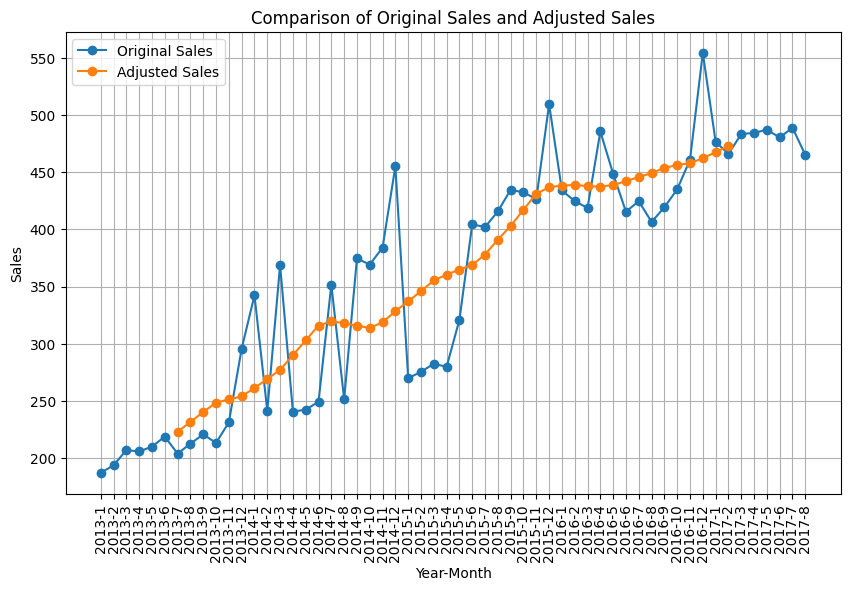

In [63]:
# 계절지수가 반영된 컬럼 추가
grouped_df['adjusted_sales'] = grouped_df['sales'] / grouped_df['2M_CMA_ratio']

# 기존 vs 계절지수 제거
plt.figure(figsize=(10, 6))
plt.plot(grouped_df['year'].astype(str) + '-' + grouped_df['month'].astype(str), grouped_df['sales'], marker='o', label='Original Sales')
plt.plot(grouped_df['year'].astype(str) + '-' + grouped_df['month'].astype(str), grouped_df['adjusted_sales'], marker='o', label='Adjusted Sales')
plt.xlabel('Year-Month')
plt.ylabel('Sales')
plt.title('Comparison of Original Sales and Adjusted Sales')
plt.xticks(rotation=90)
plt.legend()
plt.grid(True)
plt.show()


성장 정체구간 : 2014년 6월~10월, 2015년 11월~16년 6월 

# 기업의 성장성 분석 
- 이동평균 : 일정 구간을 정하고 그 구간 내의 평균치를 연속해서 계산해서 추세적인 동향을 파악
- 연평균 성장률(CAGR) : 설정한 구간마다의 증가율의 평균(기하 평균을 사용함)
(마지막 연도의 값/천 연도의 값)^(1/기간)-1 
ex. 1년차 3%, 2년차 3%, 3년차 2%의 데이터의 3년간 증가율은 (3*3*2)^(1/3)인 2.26배
- 팬 차트 : 특정 시점의 값 기준으로 데이터를 지수화 값의 변동 비율을 직관적으로 확인하기 위해 사용하는 선 차트
값 자체에서 변화의 크기가 아니라 지수화하여 변화의 크기를 보는 것이 포인트

In [110]:
grouped_df_yr = train.groupby(['year', 'family'])['sales'].sum().reset_index()
grouped_df_yr.head(5)

,year,family,sales
0,2013,AUTOMOTIVE,92323.0
1,2013,BABY CARE,0.0
2,2013,BEAUTY,47372.0
3,2013,BEVERAGES,21777880.0
4,2013,BOOKS,0.0


In [111]:
grouped_df_yr = grouped_df_yr.sort_values(['family', 'year'])
grouped_df_yr['3Y_MA'] = grouped_df_yr.groupby('family')['sales'].rolling(window=3, min_periods=1).mean().reset_index(level=0, drop=True)
pd.DataFrame(grouped_df_yr)

,year,family,sales,3Y_MA
0,2013,AUTOMOTIVE,92323.000000,92323.000000
33,2014,AUTOMOTIVE,109013.000000,100668.000000
66,2015,AUTOMOTIVE,127347.000000,109561.000000
99,2016,AUTOMOTIVE,135115.000000,123825.000000
132,2017,AUTOMOTIVE,91024.000000,117828.666667
...,...,...,...,...
32,2013,SEAFOOD,382551.096941,382551.096941
65,2014,SEAFOOD,429934.693737,406242.895339
98,2015,SEAFOOD,473797.268072,428761.019583
131,2016,SEAFOOD,457459.036986,453730.332931


## 연평균 성장률(CAGR)

In [125]:
df_sorted = grouped_df_yr.sort_values(['family', 'year'])
df_sorted['CAGR'] = np.where(np.isinf(df_sorted['3Y_MA'] / df_sorted.groupby('family')['3Y_MA'].shift(1)),
                             np.nan,
                             np.power(df_sorted['3Y_MA'] / df_sorted.groupby('family')['3Y_MA'].shift(1), 1/2) - 1)
df_sorted = df_sorted.reset_index(drop=True)
df_sorted.head(10)

,year,family,sales,3Y_MA,CAGR
0,2013,AUTOMOTIVE,92323.0,92323.000000,NaN
1,2014,AUTOMOTIVE,109013.0,100668.000000,0.044217
2,2015,AUTOMOTIVE,127347.0,109561.000000,0.043235
3,2016,AUTOMOTIVE,135115.0,123825.000000,0.063105
4,2017,AUTOMOTIVE,91024.0,117828.666667,-0.024513
5,2013,BABY CARE,0.0,0.000000,NaN
6,2014,BABY CARE,619.0,309.500000,NaN
7,2015,BABY CARE,1529.0,716.000000,0.520989
8,2016,BABY CARE,5166.0,2438.000000,0.845272
9,2017,BABY CARE,2737.0,3144.000000,0.135597


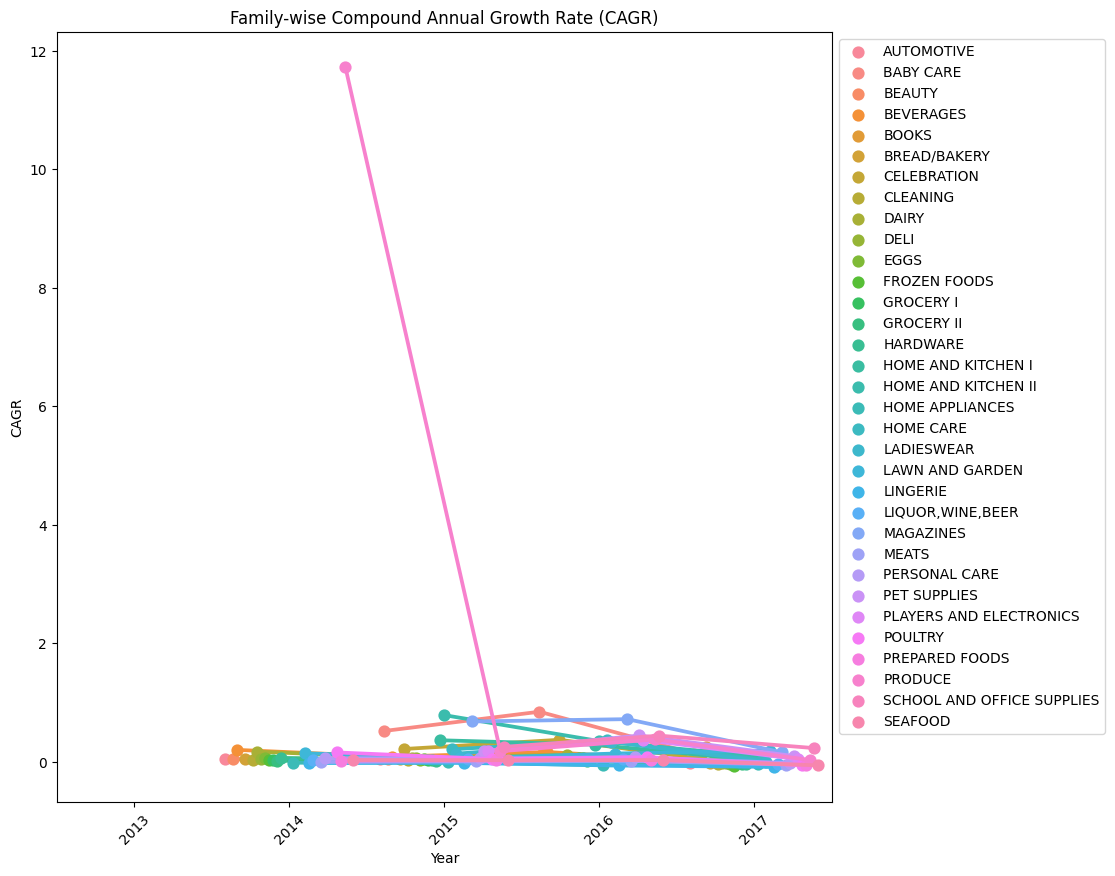

In [127]:
import seaborn as sns

plt.figure(figsize=(10, 10))
sns.pointplot(data=df_sorted, x='year', y='CAGR', hue='family', dodge=True)

plt.xlabel('Year')
plt.ylabel('CAGR')
plt.title('Family-wise Compound Annual Growth Rate (CAGR)')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.xticks(rotation=45)
plt.show()


# 팬차트 작성
- 어떤 기준이 되는 시점을 100%로 하고, 그 이후의 수치를 기준이 되는 시점에 대한 백분율로 표시해 곡선으로 나타냄
- 팬차트는 수치의 증가나 감소등 변화율로 나타내기 위해 차트의 기울기로 나타냄으로 값이 작아도 급성장을 하고 있는 항목등을 간과하지 않고 파악할 수 있음

In [133]:
df_sorted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165 entries, 0 to 164
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   year    165 non-null    int32  
 1   family  165 non-null    object 
 2   sales   165 non-null    float64
 3   3Y_MA   165 non-null    float64
 4   CAGR    119 non-null    float64
dtypes: float64(3), int32(1), object(1)
memory usage: 5.9+ KB


In [141]:
df_sorted['fan_chart'] = df_sorted.groupby('family')['sales'].transform(lambda x: (x / x.iloc[0]) * 100 if x.iloc[0] != 0 else np.nan)
df_sorted

,year,family,sales,3Y_MA,CAGR,fan_chart
0,2013,AUTOMOTIVE,92323.000000,92323.000000,NaN,100.000000
1,2014,AUTOMOTIVE,109013.000000,100668.000000,0.044217,118.077835
2,2015,AUTOMOTIVE,127347.000000,109561.000000,0.043235,137.936376
3,2016,AUTOMOTIVE,135115.000000,123825.000000,0.063105,146.350314
4,2017,AUTOMOTIVE,91024.000000,117828.666667,-0.024513,98.592983
...,...,...,...,...,...,...
160,2013,SEAFOOD,382551.096941,382551.096941,NaN,100.000000
161,2014,SEAFOOD,429934.693737,406242.895339,0.030500,112.386214
162,2015,SEAFOOD,473797.268072,428761.019583,0.027341,123.852022
163,2016,SEAFOOD,457459.036986,453730.332931,0.028706,119.581159


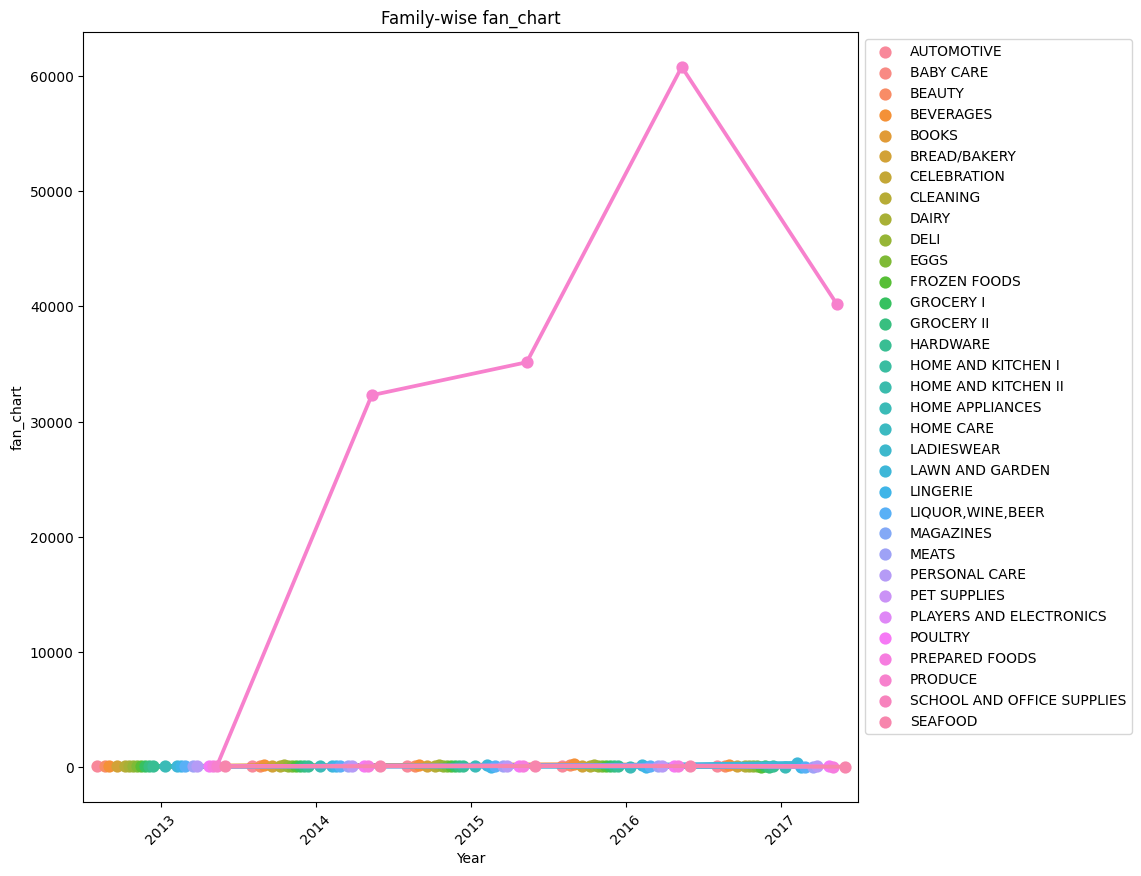

In [137]:
plt.figure(figsize=(10, 10))
sns.pointplot(data=df_sorted, x='year', y='fan_chart', hue='family', dodge=True)

plt.xlabel('Year')
plt.ylabel('fan_chart')
plt.title('Family-wise fan_chart')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.xticks(rotation=45)
plt.show()


In [145]:
#최초 년도의 매출이 너무 적은 outlier를 제거하고 살펴보자
df_sorted[df_sorted['family']=='PRODUCE']

,year,family,sales,3Y_MA,CAGR,fan_chart
150,2013,PRODUCE,7.280500e+04,7.280500e+04,NaN,100.000000
151,2014,PRODUCE,2.351253e+07,1.179267e+07,11.726981,32295.210206
152,2015,PRODUCE,2.559584e+07,1.639373e+07,0.179052,35156.712529
153,2016,PRODUCE,4.424810e+07,3.111882e+07,0.377757,60776.183563
154,2017,PRODUCE,2.927541e+07,3.303978e+07,0.030403,40210.709273


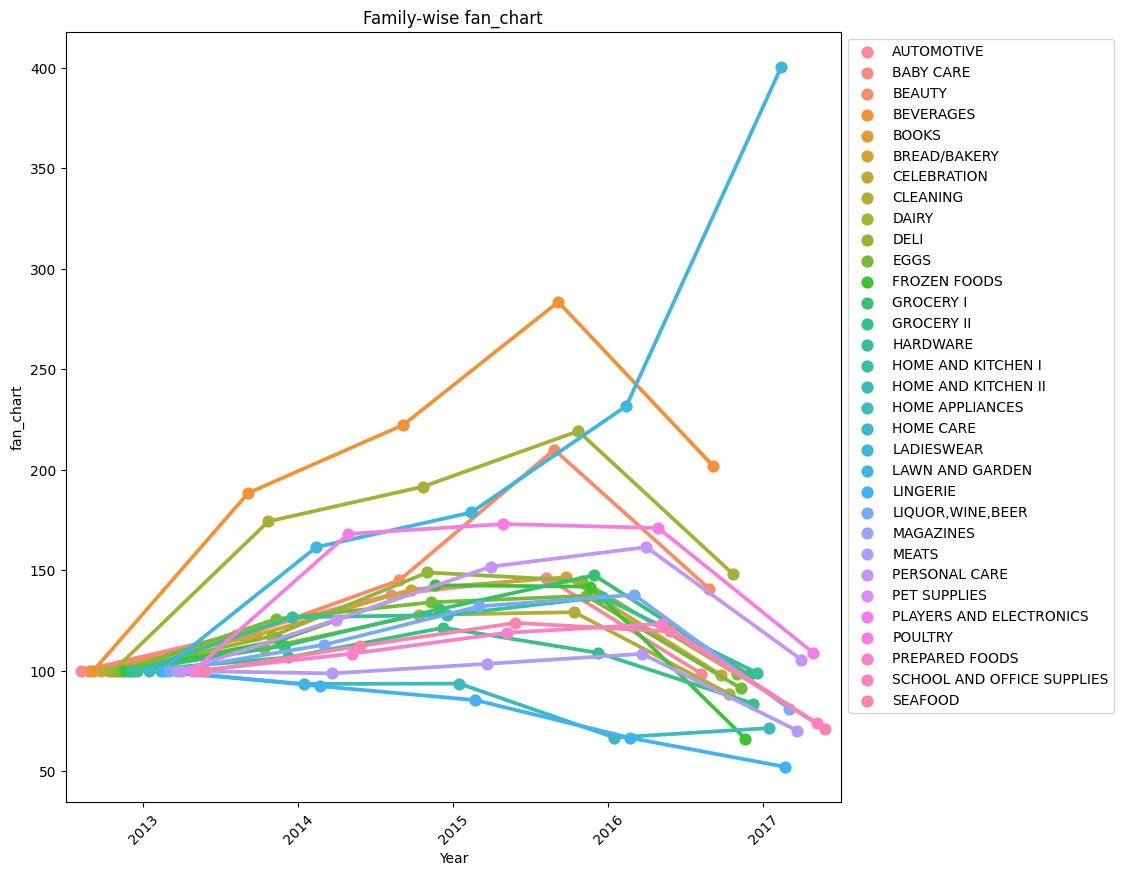

In [148]:
df_sorted_remove = df_sorted[df_sorted['family']!='PRODUCE']
plt.figure(figsize=(10, 10))
sns.pointplot(data=df_sorted_remove, x='year', y='fan_chart', hue='family', dodge=True)

plt.xlabel('Year')
plt.ylabel('fan_chart')
plt.title('Family-wise fan_chart')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.xticks(rotation=45)
plt.show()


## 계절지수

In [49]:
pivoted_df = grouped_df.pivot_table(index='year', columns='month', values='2M_CMA_ratio')
pivoted_df

month,1,2,3,4,5,6,7,8,9,10,11,12
year,,,,,,,,,,,,
2013,NaN,NaN,NaN,NaN,NaN,NaN,0.913789,0.917953,0.918380,0.858166,0.920147,1.164675
2014,1.310453,0.896854,1.330663,0.829671,0.799771,0.788807,1.100429,0.790696,1.186296,1.176774,1.205206,1.386379
2015,0.800247,0.796176,0.794766,0.776158,0.879775,1.096175,1.063701,1.063057,1.078915,1.036075,0.989527,1.166502
2016,0.990345,0.967765,0.956423,1.110605,1.022166,0.939616,0.952780,0.904667,0.924286,0.953277,1.006718,1.199579
2017,1.019288,0.985763,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
# 월별 min 행 생성
min_row = pivoted_df.min(axis=0)

# 월별 max 행 생성
max_row = pivoted_df.max(axis=0)

# 내부 평균 행 생성 (min, max 값 제외)
mean_row = pivoted_df[~pivoted_df.isin([min_row, max_row])].mean()

# 보정값 계산
correction = 12 - mean_row.sum()

# 보정값을 매기는 행 생성
correction_row = mean_row + (correction / pivoted_df.shape[1])

# 인덱스 재설정
pivoted_df = pivoted_df.reset_index()

# 새로운 행 생성
new_rows = pd.DataFrame({'year': ['min', 'max', '내부 평균', '보정값'],
                         'month': [np.nan] * 4})

# 월별 컬럼 채우기
for col in pivoted_df.columns[1:]:
    new_rows[col] = [min_row[col], max_row[col], mean_row[col], correction_row[col]]

# 데이터프레임에 행 추가
pivoted_df = pd.concat([pivoted_df, new_rows], ignore_index=True, sort=False)

# 결과 출력
pivoted_df = pivoted_df.set_index('year')
pivoted_df.index.name = '년도'
pd.DataFrame(pivoted_df)


,1,2,3,4,5,6,7,8,9,10,11,12,month
년도,,,,,,,,,,,,,
2013,NaN,NaN,NaN,NaN,NaN,NaN,0.913789,0.917953,0.918380,0.858166,0.920147,1.164675,NaN
2014,1.310453,0.896854,1.330663,0.829671,0.799771,0.788807,1.100429,0.790696,1.186296,1.176774,1.205206,1.386379,NaN
2015,0.800247,0.796176,0.794766,0.776158,0.879775,1.096175,1.063701,1.063057,1.078915,1.036075,0.989527,1.166502,NaN
2016,0.990345,0.967765,0.956423,1.110605,1.022166,0.939616,0.952780,0.904667,0.924286,0.953277,1.006718,1.199579,NaN
2017,1.019288,0.985763,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.800247,0.796176,0.794766,0.776158,0.799771,0.788807,0.913789,0.790696,0.918380,0.858166,0.920147,1.164675,NaN
max,1.310453,0.985763,1.330663,1.110605,1.022166,1.096175,1.100429,1.063057,1.186296,1.176774,1.205206,1.386379,NaN
내부 평균,1.030083,0.911640,1.027284,0.905478,0.900571,0.941533,1.007675,0.919093,1.026969,1.006073,1.030400,1.229284,NaN
보정값,1.035410,0.916966,1.032610,0.910805,0.905897,0.946859,1.013001,0.924420,1.032296,1.011399,1.035726,1.234610,NaN
